In [5]:
using Plots
using LinearAlgebra
using Statistics

In [9]:
function boids_3danimation()
    # シミュレーションパラメタ
    N = 256
    maxgeneration = 100
    # 力の強さ
    COHESION_FORCE = 0.005
    SEPARATION_FORCE = 0.6
    ALIGNMENT_FORCE = 0.01
    # 力の働く距離
    COHESION_DISTANCE = 0.6
    SEPARATION_DISTANCE = 0.02
    ALIGNMENT_DISTANCE = 0.3
    # 力の働く角度
    COHESION_ANGLE = π / 2
    SEPARATION_ANGLE = π / 2
    ALIGNMENT_ANGLE = π / 2

    # 速度の上限/下限
    MIN_VEL = 0.005
    MAX_VEL = 0.03
    # 境界で働く力（0にすると自由境界）
    BOUNDARY_FORCE = 0.05
    # 位置と速度
    x = rand(Float64, N, 3) .* 2.0 .- 1.0
    v = (rand(Float64, N, 3) .* 2.0 .- 1.0) .* MIN_VEL
    # cohesion, separation, alignmentの３つの力を代入する変数
    dv_coh = Array{Float64}(undef, N, 3)
    dv_sep = Array{Float64}(undef, N, 3)
    dv_ali = Array{Float64}(undef, N, 3)
    # 境界で働く力を代入する変数
    dv_boundary = Array{Float64}(undef, N, 3)
    
    # ある個体の位置をプロット
    samplex = Array{Float64}(undef, maxgeneration, N)
    sampley = Array{Float64}(undef, maxgeneration, N)
    samplez = Array{Float64}(undef, maxgeneration, N)
    
    # gif の生成
    anim = Animation()

    @inbounds for generation in 1:maxgeneration
        @inbounds for n in 1:N
            # ここで計算する個体の位置と速度
            x_this = x[n, :]
            v_this = v[n, :]
        
            # それ以外の個体の位置と速度の配列
            x_that = x[setdiff(1:end, [n]), :]
            v_that = v[setdiff(1:end, [n]), :]

            # 個体間の距離と角度
            x_dis = Array{Float64}(undef, size(x_that))
            @inbounds for i in 1:size(x_that)[1]
                x_dis[i, :] = x_that[i, :] - x_this
            end
        
            distance = Array{Float64}(undef, size(x_that)[1])
            @inbounds for i in 1:size(distance)[1]
                distance[i] = norm(x_dis[i, :])
            end
            
            angle = Array{Float64}(undef, size(x_that)[1])
            angle = acos.(((v_this' * x_dis') ./ (norm(v_this) * distance)'))

            # 各力が働く範囲内の個体リスト
            countn = 0
            coh_agent_x = []
            coh_list = []
            @inbounds for i in 1:size(x_that)[1]
                if (distance .< COHESION_DISTANCE)[i] == 1 && (angle .< COHESION_ANGLE)[i] == 1
                    push!(coh_list, i)
                    countn += 1
                end
            end

            @inbounds for i in 1:countn
                push!(coh_agent_x, x_that[coh_list[i], :])
            end
    
            countn = 0
            sep_agent_x = []
            sep_list = []
            @inbounds for i in 1:size(x_that)[1]
                if (distance .< SEPARATION_DISTANCE)[i] == 1 && (angle .< SEPARATION_ANGLE)[i] == 1
                    push!(sep_list, i)
                    countn += 1
                end
            end

            @inbounds for i in 1:countn
                push!(sep_agent_x, x_that[sep_list[i], :])
            end
    
            countn = 0
            ali_agent_v = []
            ali_list = []
            @inbounds for i in 1:size(v_that)[1]
                if (distance .< ALIGNMENT_DISTANCE)[i] == 1 && (angle .< ALIGNMENT_ANGLE)[i] == 1
                    push!(ali_list, i)
                    countn += 1
                end
            end

            @inbounds for i in 1:countn
                push!(ali_agent_v, v_that[ali_list[i], :])
            end
    
            # 各力の計算
            if length(coh_list) > 0
                dv_coh[n, :] = COHESION_FORCE * (mean(coh_agent_x) - x_this)
            else
                dv_coh[n, :] = zeros(Float64, 3)
            end
    
            if length(sep_list) > 0
                dv_sep[n, :] .= SEPARATION_FORCE * sum(x_this - sep_agent_x[1])
            else
                dv_sep[n, :] = zeros(Float64, 3)
            end
    
            if length(ali_list) > 0
                dv_ali[n, :] = ALIGNMENT_FORCE * (mean(ali_agent_v) - v_this)
            else
                dv_ali[n, :] = zeros(Float64, 3)
            end
        
            dist_center = norm(x_this)
            if dist_center > 1.0
                dv_boundary[n, :] = - BOUNDARY_FORCE * x_this * (dist_center - 1.0) / dist_center
            else
                dv_boundary[n, :] = zeros(Float64, 3)
            end
            
        end
    
        # 位置のアップデート
        v += dv_coh + dv_sep + dv_ali + dv_boundary
        @inbounds for i in 1:N
            v_abs = norm(v[i])
            if v_abs < MIN_VEL
                v[i, :] .= MIN_VEL * v[i] / v_abs
            elseif v_abs > MAX_VEL
                v[i, :] .= MAX_VEL * v[i] / v_abs
            end
        end      
    
        x += v

        X = x[:, 1]
        Y = x[:, 2]
        Z = x[:, 3]

        samplex[generation, :] = x[:, 1]
        sampley[generation, :] = x[:, 2]
        samplez[generation, :] = x[:, 3]
        
        plt = scatter(X, Y, Z,
            markershape=:circle,
            markersize=3,
            markeralpha=0.5,
            markercolor=:white,
            bg=:black,
            size=(600, 600),
            camera=(45, 45),
            leg=false
        )
        frame(anim, plt)
        gif(anim, "boids3d.gif", fps=3)
        
    end
    # 定向性
    println("ϕ = ", mean(v))
    println("μ = ", 1 - MIN_VEL/MAX_VEL)
    
    # 個体の位置の変動
    plot(samplex[:, 1], label="x(t)")
    plot!(sampley[:, 1], label="y(t)")
    plot!(samplez[:, 1], label="z(t)")

end

boids_3danimation (generic function with 1 method)

In [20]:
function test_animation()
    # シミュレーションパラメタ
    N = 256
    maxgeneration = 100
    # 力の強さ
    COHESION_FORCE = 0.005
    SEPARATION_FORCE = 0.5
    ALIGNMENT_FORCE = 0.01
    # 力の働く距離
    COHESION_DISTANCE = 0.8
    SEPARATION_DISTANCE = 0.03
    ALIGNMENT_DISTANCE = 0.5
    # 力の働く角度
    COHESION_ANGLE = π / 2
    SEPARATION_ANGLE = π / 2
    ALIGNMENT_ANGLE = π / 2

    # 速度の上限/下限
    MIN_VEL = 0.005
    MAX_VEL = 0.03
    # 境界で働く力（0にすると自由境界）
    BOUNDARY_FORCE = 0.05
    # 位置と速度
    x = rand(Float64, 3, N) .* 2.0 .- 1.0
    v = (rand(Float64, 3, N) .* 2.0 .- 1.0) .* MIN_VEL
    # cohesion, separation, alignmentの３つの力を代入する変数
    dv_coh = Array{Float64}(undef, 3, N)
    dv_sep = Array{Float64}(undef, 3, N)
    dv_ali = Array{Float64}(undef, 3, N)
    # 境界で働く力を代入する変数
    dv_boundary = Array{Float64}(undef, 3, N)
    
    #=
    # ある個体の位置をプロット
    samplex = Array{Float64}(undef, maxgeneration, N)
    sampley = Array{Float64}(undef, maxgeneration, N)
    samplez = Array{Float64}(undef, maxgeneration, N)
    =#
    
    # gif の生成
#     generation = 0
    anim = Animation()

    @inbounds for generation in 1:maxgeneration
        @inbounds for n in 1:N
            # ここで計算する個体の位置と速度
            x_this = x[:, n]
            v_this = v[:, n]
        
            # それ以外の個体の位置と速度の配列
            x_that = x[:, setdiff(1:end, [n])]
            v_that = v[:, setdiff(1:end, [n])]

            # 個体間の距離と角度        
            distance = Array{Float64}(undef, size(x_that)[2])
            @inbounds for i in 1:size(distance)[1]
                distance[i] = norm((x_that .- x_this)[:, i])
            end
            
            angle = Array{Float64}(undef, size(x_that)[2])
            angle = acos.(v_this' * (x_that .- x_this) ./ (norm(v_this) * distance)')

            # 各力が働く範囲内の個体リスト
            countn = 0
            coh_agent_x = []
            coh_list = []
            @inbounds for i in 1:size(x_that)[2]
                if (distance .< COHESION_DISTANCE)[i] == 1 && (angle .< COHESION_ANGLE)[i] == 1
                    push!(coh_list, i)
                    countn += 1
                end
            end

            @inbounds for i in 1:countn
                push!(coh_agent_x, x_that[:, coh_list[i]])
            end
    
            countn = 0
            sep_agent_x = []
            sep_list = []
            @inbounds for i in 1:size(x_that)[2]
                if (distance .< SEPARATION_DISTANCE)[i] == 1 && (angle .< SEPARATION_ANGLE)[i] == 1
                    push!(sep_list, i)
                    countn += 1
                end
            end

            @inbounds for i in 1:countn
                push!(sep_agent_x, x_that[:, sep_list[i]])
            end
    
            countn = 0
            ali_agent_v = []
            ali_list = []
            @inbounds for i in 1:size(v_that)[2]
                if (distance .< ALIGNMENT_DISTANCE)[i] == 1 && (angle .< ALIGNMENT_ANGLE)[i] == 1
                    push!(ali_list, i)
                    countn += 1
                end
            end

            @inbounds for i in 1:countn
                push!(ali_agent_v, v_that[:, ali_list[i]])
            end
    
            # 各力の計算
            if length(coh_list) > 0
                dv_coh[:, n] = COHESION_FORCE * (mean(coh_agent_x) - x_this)
            else
                dv_coh[:, n] = zeros(Float64, 3)
            end
    
            if length(sep_list) > 0
                dv_sep[:, n] .= SEPARATION_FORCE * sum(x_this - sep_agent_x[1])
            else
                dv_sep[:, n] = zeros(Float64, 3)
            end
    
            if length(ali_list) > 0
                dv_ali[:, n] = ALIGNMENT_FORCE * (mean(ali_agent_v) - v_this)
            else
                dv_ali[:, n] = zeros(Float64, 3)
            end
        
            dist_center = norm(x_this)
            if dist_center > 1.0
                dv_boundary[:, n] = - BOUNDARY_FORCE * x_this * (dist_center - 1.0) / dist_center
            else
                dv_boundary[:, n] = zeros(Float64, 3)
            end
            
        end
    
        # 位置のアップデート
        v += dv_coh + dv_sep + dv_ali + dv_boundary
        @inbounds for i in 1:N
            v_abs = norm(v[i])
            if v_abs < MIN_VEL
                v[:, i] .= MIN_VEL * v[i] / v_abs
            elseif v_abs > MAX_VEL
                v[:, i] .= MAX_VEL * v[i] / v_abs
            end
        end      
    
        x += v
        
        X = x'[:, 1]
        Y = x'[:, 2]
        Z = x'[:, 3]
        
        #=
        samplex[generation, :] = x[:, 1]
        sampley[generation, :] = x[:, 2]
        samplez[generation, :] = x[:, 3]
        =#
        
        plt = scatter(X, Y, Z,
            markershape=:circle,
            markersize=3,
            markeralpha=0.5,
            markercolor=:white,
            bg=:black,
            size=(600, 600),
            camera=(45, 45),
            leg=false
        )
        frame(anim, plt)
        gif(anim, "test3d.gif", fps=3)
        
#         generation += 1
    end
    println(mean(v))
    #=
    plot(samplex[:, 1], label="x(t)")
    plot!(sampley[:, 1], label="y(t)")
    plot!(samplez[:, 1], label="z(t)")
    =#
    
end

test_animation (generic function with 1 method)

In [25]:
function boids_2danimation()
    # シミュレーションパラメタ
    N = 256
    maxgeneration = 100
    # 力の強さ
    COHESION_FORCE = 0.005
    SEPARATION_FORCE = 0.5
    ALIGNMENT_FORCE = 0.01
    # 力の働く距離
    COHESION_DISTANCE = 0.6
    SEPARATION_DISTANCE = 0.01
    ALIGNMENT_DISTANCE = 0.3
    # 力の働く角度
    COHESION_ANGLE = π / 2
    SEPARATION_ANGLE = π / 2
    ALIGNMENT_ANGLE = π / 2

    # 速度の上限/下限
    MIN_VEL = 0.005
    MAX_VEL = 0.03
    # 境界で働く力（0にすると自由境界）
    BOUNDARY_FORCE = 0.05
    # 位置と速度
    x = rand(Float64, N, 2) .* 2.0 .- 1.0
    v = (rand(Float64, N, 2) .* 2.0 .- 1.0) .* MIN_VEL
    # cohesion, separation, alignmentの３つの力を代入する変数
    dv_coh = Array{Float64}(undef, N, 2)
    dv_sep = Array{Float64}(undef, N, 2)
    dv_ali = Array{Float64}(undef, N, 2)
    # 境界で働く力を代入する変数
    dv_boundary = Array{Float64}(undef, N, 2)
    
    # ある個体の位置をプロット
    samplex = Array{Float64}(undef, maxgeneration, N)
    sampley = Array{Float64}(undef, maxgeneration, N)
    
    # gif の生成
#     generation = 0
    anim = Animation()

    @inbounds for generation in 1:maxgeneration
        @inbounds for n in 1:N
            # ここで計算する個体の位置と速度
            x_this = x[n, :]
            v_this = v[n, :]
        
            # それ以外の個体の位置と速度の配列
            x_that = x[setdiff(1:end, [n]), :]
            v_that = v[setdiff(1:end, [n]), :]

            # 個体間の距離と角度
            x_dis = Array{Float64}(undef, size(x_that))
            @inbounds for i in 1:size(x_that)[1]
                x_dis[i, :] = x_that[i, :] - x_this
            end
        
            distance = Array{Float64}(undef, size(x_that)[1])
            @inbounds for i in 1:size(distance)[1]
                distance[i] = norm(x_dis[i, :])
            end
            
            angle = Array{Float64}(undef, size(x_that)[1])
            angle = acos.(((v_this' * x_dis') ./ (norm(v_this) * distance)'))

            # 各力が働く範囲内の個体リスト
            countn = 0
            coh_agent_x = []
            coh_list = []
            @inbounds for i in 1:size(x_that)[1]
                if (distance .< COHESION_DISTANCE)[i] == 1 && (angle .< COHESION_ANGLE)[i] == 1
                    push!(coh_list, i)
                    countn += 1
                end
            end

            @inbounds for i in 1:countn
                push!(coh_agent_x, x_that[coh_list[i], :])
            end
    
            countn = 0
            sep_agent_x = []
            sep_list = []
            @inbounds for i in 1:size(x_that)[1]
                if (distance .< SEPARATION_DISTANCE)[i] == 1 && (angle .< SEPARATION_ANGLE)[i] == 1
                    push!(sep_list, i)
                    countn += 1
                end
            end

            @inbounds for i in 1:countn
                push!(sep_agent_x, x_that[sep_list[i], :])
            end
    
            countn = 0
            ali_agent_v = []
            ali_list = []
            @inbounds for i in 1:size(v_that)[1]
                if (distance .< ALIGNMENT_DISTANCE)[i] == 1 && (angle .< ALIGNMENT_ANGLE)[i] == 1
                    push!(ali_list, i)
                    countn += 1
                end
            end

            @inbounds for i in 1:countn
                push!(ali_agent_v, v_that[ali_list[i], :])
            end
    
            # 各力の計算
            if length(coh_list) > 0
                dv_coh[n, :] = COHESION_FORCE * (mean(coh_agent_x) - x_this)
            else
                dv_coh[n, :] = zeros(Float64, 2)
            end
    
            if length(sep_list) > 0
                dv_sep[n, :] .= SEPARATION_FORCE * sum(x_this - sep_agent_x[1])
            else
                dv_sep[n, :] = zeros(Float64, 2)
            end
    
            if length(ali_list) > 0
                dv_ali[n, :] = ALIGNMENT_FORCE * (mean(ali_agent_v) - v_this)
            else
                dv_ali[n, :] = zeros(Float64, 2)
            end
        
            dist_center = norm(x_this)
            if dist_center > 1.0
                dv_boundary[n, :] = - BOUNDARY_FORCE * x_this * (dist_center - 1.0) / dist_center
            else
                dv_boundary[n, :] = zeros(Float64, 2)
            end
            
        end
    
        # 位置のアップデート
        v += dv_coh + dv_sep + dv_ali + dv_boundary
        @inbounds for i in 1:N
            v_abs = norm(v[i])
            if v_abs < MIN_VEL
                v[i, :] .= MIN_VEL * v[i] / v_abs
            elseif v_abs > MAX_VEL
                v[i, :] .= MAX_VEL * v[i] / v_abs
            end
        end      
    
        x += v

        X = x[:, 1]
        Y = x[:, 2]

        samplex[generation, :] = x[:, 1]
        sampley[generation, :] = x[:, 2]
        
        plt = scatter(X, Y,
            markershape=:circle,
            markersize=3,
            markeralpha=0.5,
            markercolor=:white,
            bg=:black,
            size=(600, 600),
            camera=(45, 45),
            leg=false
        )
        frame(anim, plt)
        gif(anim, "boids2d.gif", fps=3)
        
#         generation += 1
    end
    println(mean(v))
    plot(samplex[:, 1], label="x(t)")
    plot!(sampley[:, 1], label="y(t)")
    
end

boids_2danimation (generic function with 1 method)

┌ Info: Saved animation to 
│   fn = /Users/yanaichiharu/c_data/julia_dir/boids_simu/boids3d.gif
└ @ Plots /Users/yanaichiharu/.julia/packages/Plots/cc8wh/src/animation.jl:98
┌ Info: Saved animation to 
│   fn = /Users/yanaichiharu/c_data/julia_dir/boids_simu/boids3d.gif
└ @ Plots /Users/yanaichiharu/.julia/packages/Plots/cc8wh/src/animation.jl:98
┌ Info: Saved animation to 
│   fn = /Users/yanaichiharu/c_data/julia_dir/boids_simu/boids3d.gif
└ @ Plots /Users/yanaichiharu/.julia/packages/Plots/cc8wh/src/animation.jl:98
┌ Info: Saved animation to 
│   fn = /Users/yanaichiharu/c_data/julia_dir/boids_simu/boids3d.gif
└ @ Plots /Users/yanaichiharu/.julia/packages/Plots/cc8wh/src/animation.jl:98
┌ Info: Saved animation to 
│   fn = /Users/yanaichiharu/c_data/julia_dir/boids_simu/boids3d.gif
└ @ Plots /Users/yanaichiharu/.julia/packages/Plots/cc8wh/src/animation.jl:98
┌ Info: Saved animation to 
│   fn = /Users/yanaichiharu/c_data/julia_dir/boids_simu/boids3d.gif
└ @ Plots /Users/yanaichihar

ϕ = 0.0005758117365104117
μ = 0.8333333333333333
160.979968 seconds (71.99 M allocations: 6.839 GiB, 1.71% gc time)


┌ Info: Saved animation to 
│   fn = /Users/yanaichiharu/c_data/julia_dir/boids_simu/boids3d.gif
└ @ Plots /Users/yanaichiharu/.julia/packages/Plots/cc8wh/src/animation.jl:98


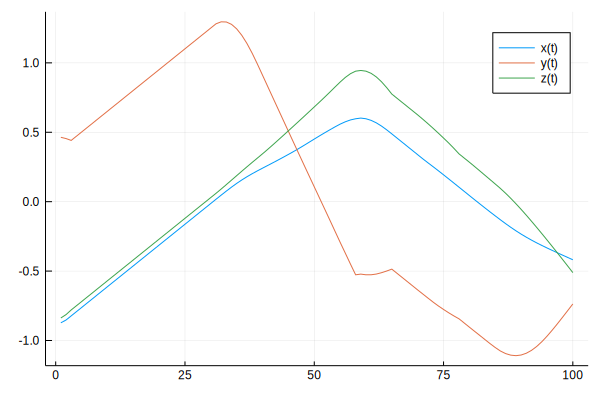

In [10]:
@time boids_3danimation()